In [1]:
%matplotlib inline
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import jieba
from gensim.models import KeyedVectors

In [2]:
# 导入词向量
cn_word_vecs = KeyedVectors.load_word2vec_format(
    'sgns.zhihu.bigram', binary=False)
ebd_dim = cn_word_vecs[u'我'].shape[0]

In [3]:
POS = os.path.join(os.getcwd(), 'fix_pos')
NEG = os.path.join(os.getcwd(), 'fix_neg')

# 存储所有评价，每例评价为一条string
train_text_raw = []
for file_name in os.listdir(POS):
    with open(os.path.join(POS, file_name), 'r') as f:
        train_text_raw.append(f.read().strip().decode('utf-8'))

for file_name in os.listdir(NEG):
    with open(os.path.join(NEG, file_name), 'r') as f:
        train_text_raw.append(f.read().strip().decode('utf-8'))

In [6]:
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
word_lists = []
pattern = ur"[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+"
for text in train_text_raw:
    p_text = re.sub(pattern, "", text)
    cut = jieba.cut(p_text)
    cut_list = []
    word_list = []
    for word in cut:
        word_list.append(word)
        try:
            cut_list.append(cn_word_vecs.vocab[word].index)
        except KeyError:
            cut_list.append(0)
    train_tokens.append(cut_list)
    word_lists.append(word_list)
    
# 打印一些tokenize后的样本
samples = random.sample(range(len(train_tokens)), 3)
for i in samples:
    print u", ".join(word_lists[i])
    print train_tokens[i]
    print '-'*80

由于, 火车, 时间, 不得不, 在, 早上, 六点, 到, 酒店, 等到, 快, 八点, 才, 入住, 好惨, 通过, 携程, 预订, 标明, 是, 双早, 却, 给, 了, 一张, 早餐, 卷券害, 得, 要, 回, 房间, 吃, 方便面, 房间, 宽带, 总是, 断, 不过, 环境, 真是, 不错
[491, 2241, 139, 1569, 15, 1001, 0, 48, 1845, 2374, 488, 0, 126, 11780, 41456, 259, 14862, 21262, 20155, 4, 0, 141, 51, 3, 0, 4656, 0, 117, 20, 494, 1487, 116, 7998, 1487, 22380, 412, 2066, 223, 578, 418, 562]
--------------------------------------------------------------------------------
在, 南山区, 办事, 的话, 住, 这里, 还, 算, 方便, 门口, 往, 哪个, 方向, 的, 车, 都, 有, 就是, 稍微, 有点, 吵, 啊
[15, 122427, 6474, 425, 659, 307, 40, 640, 1419, 1235, 478, 884, 974, 1, 356, 11, 8, 25, 1532, 348, 5020, 90]
--------------------------------------------------------------------------------
第二次, 住, 的, 时候, 酒店, 说, 我, 在, 房间, 里, 消费, 很, 冤枉
[0, 659, 1, 43, 1845, 16, 6, 15, 1487, 63, 1622, 34, 12374]
--------------------------------------------------------------------------------


In [7]:
num_tokens = np.array([len(tokens) for tokens in train_tokens])
print '平均长度为 %f' % np.mean(num_tokens)
print '最长的评论长度为 %d' % np.max(num_tokens)

平均长度为 71.458750
最长的评论长度为 1540


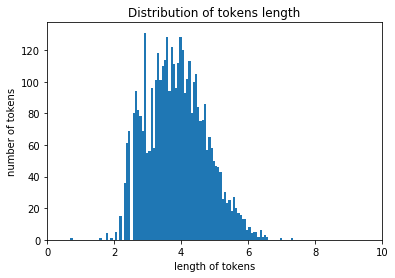

In [8]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [9]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

236

In [10]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_word_vecs.index2word[i]
        else:
            text = text + ' '
    return text

In [11]:
print reverse_tokens(train_tokens[100])
print reverse_tokens(train_tokens[2200])

房间每天都有免费水果赠送这一点比较好还有好多书籍和摄影著作摆在房间里据说都是合庆董事长自己编写拍摄的太有才了
看了前面的点评感觉此酒店应该不错所以这次去慈溪定了国脉酒店结果大失所望酒店位置不错298的大床房窗外景色好公园小街不满意的地方：一房间 地毯肯定 未洗污渍满地如果像走道一样铺大理石反而干净得多；椅背床背都不干净房间居然还有一个大苍蝇；二洗澡的花洒非常不好用三大堂的灯太昏暗头晕四前台的服务小姐态度比较生硬；五酒店所有的商务单人大床 但是低下是冷却塔厨房烟道比较嘈


In [27]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [28]:
num_words = 50001
ebd_matrix = np.zeros((num_words, ebd_dim))
for i in range(num_words):
    ebd_matrix[i,:] = cn_word_vecs[cn_word_vecs.index2word[i]]
ebd_matrix = ebd_matrix.astype('float32')

In [47]:
# 处理缺失数据

# 方式1， 截断长序列的前面部分，在短序列前面部分补0 测试集accuracy 84%
# train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
#                             padding='pre', truncating='pre')
# train_pad[ train_pad>=num_words ] = 0

# 方式2， 截断长序列的后面部分，在短序列后面部分补0 测试集accuracy 88%
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='post', truncating='post')
train_pad[ train_pad>=num_words ] = 0

In [48]:
train_target = np.concatenate((np.ones(2000),np.zeros(2000)))

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [50]:
print reverse_tokens(x_train[100])
print 'class: %d', y_train[100]

住的是 房房间超大环境一流价钱不算高258 2早 是服务有点跟不上总体不错                                                                                                                                                                                                                     
class: %d 1.0


In [51]:
model = Sequential()
# 第一层 embeding
model.add(Embedding(num_words,
                    ebd_dim,
                    weights=[ebd_matrix],
                    input_length=max_tokens,
                    mask_zero=True,
                    trainable=False))
model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=16, return_sequences=False))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 236, 300)          15000300  
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 15,020,605
Trainable params: 20,305
Non-trainable params: 15,000,300
_________________________________________________________________


In [52]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)
# 定义callback函数
callbacks = [
    earlystopping, 
    lr_reduction
]

In [53]:
# 开始训练
model.fit(x_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 3240 samples, validate on 360 samples
Epoch 1/20
3240/3240 [==============================] - 5s 1ms/step - loss: 0.6536 - acc: 0.6194 - val_loss: 0.6072 - val_acc: 0.7028
Epoch 2/20
3240/3240 [==============================] - 4s 1ms/step - loss: 0.5153 - acc: 0.7580 - val_loss: 0.4313 - val_acc: 0.8278
Epoch 3/20
3240/3240 [==============================] - 4s 1ms/step - loss: 0.3908 - acc: 0.8373 - val_loss: 0.3484 - val_acc: 0.8639
Epoch 4/20
3240/3240 [==============================] - 4s 1ms/step - loss: 0.3383 - acc: 0.8645 - val_loss: 0.3275 - val_acc: 0.8639
Epoch 5/20
3240/3240 [==============================] - 4s 1ms/step - loss: 0.3134 - acc: 0.8716 - val_loss: 0.3143 - val_acc: 0.8861
Epoch 6/20
3240/3240 [==============================] - 4s 1ms/step - loss: 0.2767 - acc: 0.8935 - val_loss: 0.3063 - val_acc: 0.8722
Epoch 7/20
3240/3240 [==============================] - 4s 1ms/step - loss: 0.2647 - acc: 0.8975 - val_loss: 0.2978 - val_acc: 0.8778
Epoch 8/20
3240

In [54]:
result = model.evaluate(x_test, y_test)
print 'Accuracy:%f'%result[1]

400/400 [==============================] - 0s 1ms/step
Accuracy:0.880000


In [55]:
def predict_sentiment(text):
    print text
    p_text = re.sub(pattern, "", text)
    cut = jieba.cut(p_text)
    cut_list = []
    for word in cut:
        try:
            cut_list.append(cn_word_vecs.vocab[word].index)
        except KeyError:
            cut_list.append(0)
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    tokens_pad[ tokens_pad>=num_words ] = 0
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print '是一例正面评价','output=%.2f'%coef
    else:
        print '是一例负面评价','output=%.2f'%coef

In [56]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
是一例负面评价 output=0.33
酒店卫生条件非常不好
是一例负面评价 output=0.09
床铺非常舒适
是一例正面评价 output=0.82
房间很凉，不给开暖气
是一例负面评价 output=0.26
房间很凉爽，空调冷气很足
是一例正面评价 output=0.65
酒店环境不好，住宿体验很不好
是一例负面评价 output=0.08
房间隔音不到位
是一例负面评价 output=0.18
晚上回来发现没有打扫卫生
是一例负面评价 output=0.23
因为过节所以要我临时加钱，比团购的价格贵
是一例负面评价 output=0.07
